In [28]:
import pickle
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras import backend as K
%matplotlib notebook

In [7]:
def plot_2d_landmarks(img, true, pred):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.imshow(img.reshape((80,120,3)))
    ax.autoscale(False)
    ax.plot(pred[:,0], pred[:,1], '+w')
    plt.plot(true[:,0], true[:,1], '.r')
    ax.axis('off')
    plt.show()
    
def p_norm_loss(y_true, y_pred):
    return K.mean(K.pow(y_pred - y_true, 4), axis=-1)


In [84]:
landmark_dim = 2
# Load data
with open('all_data.pkl', 'rb') as f:
    images_train, images_test, ldmks_2d_train, ldmks_2d_test, ldmks_3d_train, ldmks_3d_test, head_pose_train, head_pose_test, look_vec_train, look_vec_test = pickle.load(f)

num_samples = images_test.shape[0]

In [94]:
# Load the saved model
# model = load_model('landmark_cnn.h5', custom_objects={'p_norm_loss': p_norm_loss})
# Load the saved model
model = load_model('landmark_cnn_v6_ploss_retarded.h5', custom_objects={'p_norm_loss': p_norm_loss}) # 4-norm

model2 = load_model('landmark_cnn_v5_mse_retarded_best.h5', custom_objects={'p_norm_loss': p_norm_loss}) # MSE

model3 = load_model('landmark_cnn_v7_mae_retarded.h5', custom_objects={'p_norm_loss': p_norm_loss}) # MAE

model_3d = load_model('landmark_cnn_3d.h5', custom_objects={'p_norm_loss': p_norm_loss}) # MSE 3D

In [95]:
ldmks_2d_test = np.reshape(ldmks_2d_test, (num_samples, 28,landmark_dim))
ldmks_3d_test = np.reshape(ldmks_3d_test, (num_samples, 28,3))
head_pose_test_raw = np.reshape(head_pose_test, (num_samples, 3,3))

pred_landmarks = model.predict({'input_img': images_test, 'head_pose': head_pose_test})
pred_landmarks = np.reshape(pred_landmarks, (num_samples, 28,landmark_dim))

pred_landmarks_2 = model2.predict({'input_img': images_test, 'head_pose': head_pose_test})
pred_landmarks_2 = np.reshape(pred_landmarks_2, (num_samples, 28,landmark_dim))

pred_landmarks_3 = model3.predict({'input_img': images_test, 'head_pose': head_pose_test})
pred_landmarks_3 = np.reshape(pred_landmarks_3, (num_samples, 28,landmark_dim))

pred_landmarks_3D = model_3d.predict({'input_img': images_test, 'head_pose': head_pose_test})
pred_landmarks_3D = np.reshape(pred_landmarks_3D, (num_samples, 28, 3))

<IPython.core.display.Javascript object>


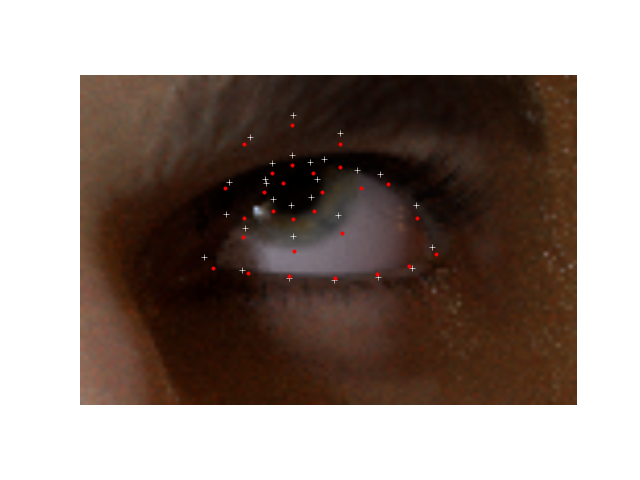

<IPython.core.display.Javascript object>


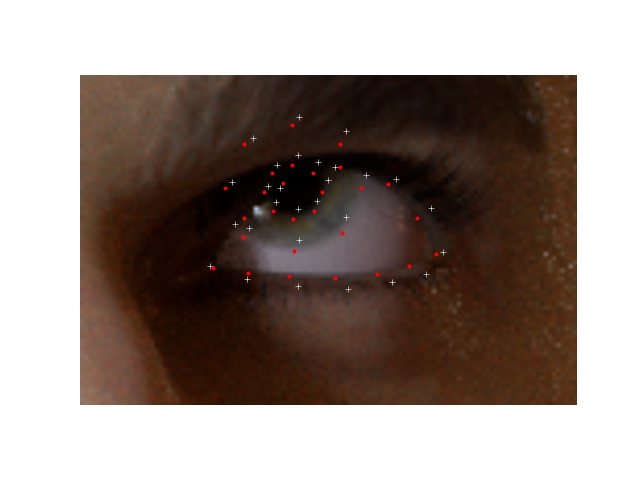

In [96]:
i = np.random.choice(num_samples)
plot_2d_landmarks(images_test[i,:,:,:], ldmks_2d_test[i,:,:], pred_landmarks_2[i,:,:])
plot_2d_landmarks(images_test[i,:,:,:], ldmks_2d_test[i,:,:], pred_landmarks_3[i,:,:])

<IPython.core.display.Javascript object>


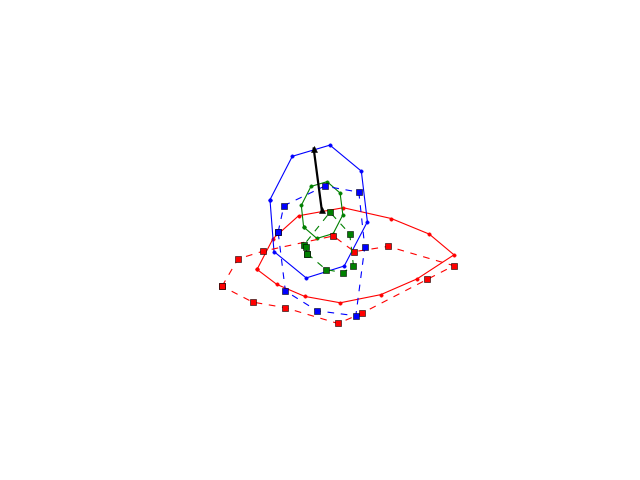

In [101]:
def plot_2d_landmarks(img, true, pred):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.imshow(img.reshape((80,120,3)))
    ax.autoscale(False)
    ax.plot(pred[:,0], pred[:,1], '+w')
    plt.plot(true[:,0], true[:,1], '.r')
    ax.axis('off')
    plt.show()


def plot_3d_landmarks(true, pred, gaze_vector):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    Z = true
    ax.plot(np.hstack((Z[0:12,0], Z[0,0])) , np.hstack((Z[0:12,1], Z[0,1])), np.hstack((Z[0:12,2], Z[0,2])), c='r', marker='.')
    ax.plot(np.hstack((Z[12:20,0], Z[12,0])) , np.hstack((Z[12:20,1], Z[12,1])), np.hstack((Z[12:20,2], Z[12,2])), c='b', marker='.')
    ax.plot(np.hstack((Z[20:28,0], Z[20,0])) , np.hstack((Z[20:28,1], Z[20,1])), np.hstack((Z[20:28,2], Z[20,2])), c='g', marker='.')
    
    Z = np.vstack((np.mean(Z[20:28,:], axis=0), np.mean(Z[20:28,:], axis=0) - 0.1 * gaze_vector))
    ax.plot(Z[:,0], Z[:,1], Z[:,2], c='k', marker='^', linewidth=2.0)
    
    Z = pred
    ax.plot(np.hstack((Z[0:12,0], Z[0,0])) , np.hstack((Z[0:12,1], Z[0,1])), np.hstack((Z[0:12,2], Z[0,2])), c='r', marker='s', ls = 'dashed')
    ax.plot(np.hstack((Z[12:20,0], Z[12,0])) , np.hstack((Z[12:20,1], Z[12,1])), np.hstack((Z[12:20,2], Z[12,2])), c='b', marker='s', ls = 'dashed')
    ax.plot(np.hstack((Z[20:28,0], Z[20,0])) , np.hstack((Z[20:28,1], Z[20,1])), np.hstack((Z[20:28,2], Z[20,2])), c='g', marker='s', ls = 'dashed')
    
    ax.axis('off')
    plt.show()


def p_norm_loss(y_true, y_pred):
    return K.mean(K.pow(y_pred - y_true, 4), axis=-1)

plot_3d_landmarks(ldmks_3d_test[i,:,:], pred_landmarks_3D[i,:,:], look_vec_test[i,:])

In [98]:
look_vec_test.shape

(2277, 3)

In [99]:
look_vec_test[i,:]

array([ 0.03973389, -0.38354492, -0.92285156], dtype=float16)